# <center>Recurrent Neural Network(RNN)

<br>

In this part we will try to build and train Recurrent Neural Network for our time series data. Let's first take a brief overview of RNN.<br>

Recurrent neural networks, also known as RNNs, are a class of neural networks that allow previous outputs to be used as inputs while having hidden states. Unlike standard feedforward neural networks, RNN has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video).<br>

Instead of neurons, RNN networks have memory blocks that are connected through layers.
### Why RNN for Time Series?
RNN networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series.
<br><br>
We will use Keras with Tensorflow at backend for building our Neural Network.

## Importing the Required Libraries

In [1]:
# import necessary files
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error,  mean_absolute_error
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/MLESS Project

/content/drive/.shortcut-targets-by-id/10uK4sKygbtZVaBiggTrdSFd7glFgkGeQ/MLESS Project


### Single RNN architecture

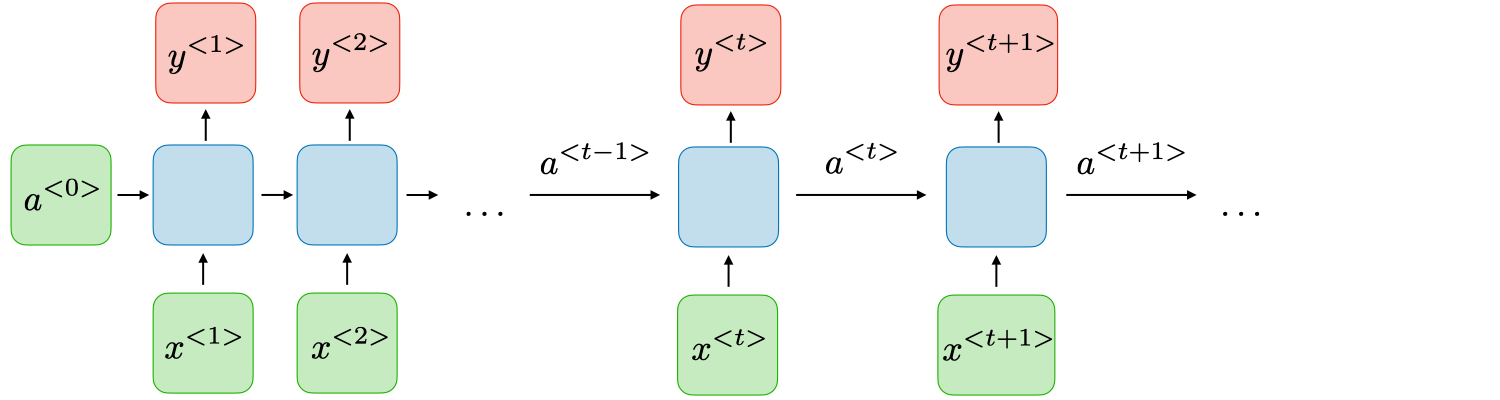

#### Designing the Architecture of  RNN neural network

In [4]:
# Let's design the Architecture of our RNN neural network
def fit_RNN(scaled_train_data, time_steps, n_features, batch_size = 8, activation = 'relu', epochs = 10):
    ''''
        train_data: train data for training the model
        test_data: test data for evaluating the model
        activation: activation function. Default is 'relu'.
        return: rnn model

        Note:
        1) time_steps: 12 for monthly, 365 for daily data is preffered.
        2) batch size: let's keep batch size to any fixed size. We will fix it at 8.
    
    '''
    # define generator object to produce batches for training/validation.
    generator = TimeseriesGenerator(data = scaled_train_data, targets = scaled_train_data, length = time_steps, batch_size = batch_size)

    # Since we want to build RNN network, In Keras we can simply stack multiple layers on top of each other,
    # for this we need to initialize the model as Sequential().
    model = Sequential()

    # add input layer. 
    #           units: We can take units as any no of dimensions(positive) for the outer space.
    #           activation: softmax, relu, softsign etc.
    model.add(SimpleRNN(units = 256, activation = activation, input_shape = (time_steps, n_features),return_sequences=True))

    # Dropout: Every RNN layer should be accompanied by a Dropout layer.
    #          20% is often used as a good compromise between retaining model accuracy
    #          and preventing overfitting.
    model.add(Dropout(0.2))

    model.add(SimpleRNN(units = 128, activation = activation, input_shape = (time_steps, n_features),return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(16))
    # add output layer the model. Since our model is making 
    # single predictions we'll take output layer as 1.
    model.add(Dense(1))
    # compile the model. Generally we use 'adam' optimiser. Let's take loss as mean square error. 
    model.compile(optimizer='adam', loss='mse')
    # fit the rnn neural network
    model.fit_generator(generator, epochs = epochs)
    
    return model

In [5]:
# function for predicting data for RNN
def predict_RNN(scaled_train_data, scaler, train_data, test_data, time_steps, n_features, rnn_model):
    '''
        scaled_train_data: scaled train data.
        scaler: MinMaxScaler object for inverting transformations.
        scaled_test_data:  scaled test data.
        train_data:  train data.
        test_data:   test data.
        time_steps: Time steps
        n_features: Number of units in one input sequence.
        rnn_model: The RNN model to evaluate.
        return : Predicted values.
    '''
    # for storing predicted values.
    pred_list = []
    batch = scaled_train_data[-time_steps:].reshape(1, time_steps, n_features)
    for i in range(time_steps):
        pred_list.append(rnn_model.predict(batch)[0])
        batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis = 1)
    # creating dataframe of predicted values
    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=test_data.index, columns = ['Predictions'])
    # plotting the results
    plt.figure(figsize = (20, 5))
    plt.plot(train_data.index, train_data, label = 'Train')
    plt.plot(test_data.index, test_data, label = 'Test')
    plt.plot(df_predict.index, df_predict, label = 'Prediction')
    plt.legend(loc='best', fontsize='xx-large')
    # print pollutant name
    print('\nPredictions of ',train_data.columns.values[0])
    plt.show()
    
    return df_predict

In [6]:
# function for evaluating the model
def evaluate_RNN(actual, predicted, file_path_and_name):
    '''
        actual: actual values
        predicted: predicted values
        return: None
        
        calculates Mean square Error, Mean Absolute error and Root Mean Square Error
        
    '''
    # print pollutant name
    print('\nEvaluation of ',actual.columns.values[0])
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 4)))
    print('The Mean Absolute Error of the forecasts is {}'.format(round(mae, 4)))
    print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse,4)))
    
    # save results locally
    if not os.path.exists('predictions'): os.mkdir('predictions')
    if not os.path.exists(file_path_and_name):
        # create result dataframe for storing evaluation results(initialized with zeros)
        pd.DataFrame(data = {'EM' : ['mse','mae','rmse'] , 'PM2.5': [0.0,0.0,0.0], 'PM10': [0.0,0.0,0.0],
                                  'SO2': [0.0,0.0,0.0], 'NO2': [0.0,0.0,0.0],
                                  'CO': [0.0,0.0,0.0], 'O3': [0.0,0.0,0.0],


                            }).to_csv(file_path_and_name,index = False)
        
    # read the rnn.csv file
    result = pd.read_csv(file_path_and_name, dtype = {'EM':str})
    # set index as EM (Evaluation Matrix)
    result.set_index('EM', inplace = True)
    # write all the results
    result[actual.columns.values[0]]['mse'] = round(mse, 4)
    result[actual.columns.values[0]]['mae'] = round(mae, 4)
    result[actual.columns.values[0]]['rmse'] = round(rmse, 4)
    # save the file after writing
    result.to_csv(file_path_and_name)
    # display successfull write message
    print('\nResults for {} successfully saved to {}'.format(actual.columns.values[0],file_path_and_name))

In [7]:
# Scaling Train-Test data
def transform_data(train_data):
    '''
        train_data: Train data
        test_data: Test data
        return: (scaled_train_data, scaler)
    '''
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    
    return scaler.transform(train_data), scaler 

#### Applying RNN to daily data of PM2.5
Let's first apply our RNN model to daily data of PM2.5.

In [8]:
# loading the daily data of PM2.5
train_PM25 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])

In order to feed our data into the neural network We need to first format our data into the specific format. Usually we scale data between either between (0,1) or (-1,1). We will use MinMaxScaler of scikitlearn library which will automatically scale the data.

In [9]:
# transform train_PM25 data
scaled_train_PM25, scaler = transform_data(train_PM25)

In [10]:
# define parameters for the RNN model
# time_steps: 12 for monthly, 365 for daily data is preffered.
time_steps = 365
# no of units as n_feature: Since we have only one feature so we will take n_feature as 1.
n_feature = 1
# fit the RNN model
model = fit_RNN(scaled_train_PM25, time_steps, n_feature)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


92/92 [==============================] - 90s 934ms/step - loss: 0.0151
Epoch 2/10
92/92 [==============================] - 90s 974ms/step - loss: 0.0125
Epoch 3/10
92/92 [==============================] - 100s 1s/step - loss: 0.0120
Epoch 4/10
92/92 [==============================] - 80s 873ms/step - loss: 0.0128
Epoch 5/10
92/92 [==============================] - 81s 879ms/step - loss: 0.0118
Epoch 6/10
92/92 [==============================] - 81s 878ms/step - loss: 0.0119
Epoch 7/10
92/92 [==============================] - 81s 881ms/step - loss: 0.0114
Epoch 8/10
92/92 [==============================] - 82s 894ms/step - loss: 0.0117
Epoch 9/10
92/92 [==============================] - 81s 885ms/step - loss: 0.0114
Epoch 10/10
92/92 [==============================] - 84s 916ms/step - loss: 0.0108



Predictions of  PM2.5


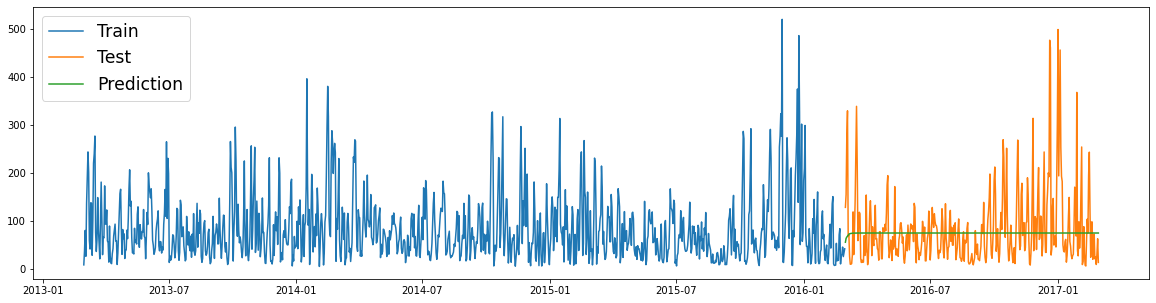

In [11]:
# Predict PM2.5 using RNN
predictions = predict_RNN(scaled_train_PM25, scaler, train_PM25, test_PM25,time_steps, n_feature, model)

In [12]:
# Plot the predictions for PM2.5 pollutant
evaluate_RNN(test_PM25, predictions,"/content/drive/MyDrive/MLESS Project/predictions/Gucheng/daily/RNN_PM2_5.csv")


Evaluation of  PM2.5
The Mean Squared Error of the forecasts is 5944.6468
The Mean Absolute Error of the forecasts is 50.9088
The Root Mean Squared Error of the forecasts is 77.1015

Results for PM2.5 successfully saved to /content/drive/MyDrive/MLESS Project/predictions/Gucheng/daily/RNN_PM2_5.csv


It's look like our model is having a hard time fitting the daily data. Hyperparameter Tuning is required. Since the daily data is quite large, Hyperparameter Tuning will take a lot of time. So due to Time constraints let's move on monthly data.

#### Applying RNN model on all the monthly pollutants data

In [13]:
# load all monthly datasets
train_PM25 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])
train_PM10 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_PM10.csv', parse_dates = [0], index_col = [0])
test_PM10 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_PM10.csv', parse_dates = [0], index_col = [0])
train_SO2 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_SO2.csv', parse_dates = [0], index_col = [0])
test_SO2 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_SO2.csv', parse_dates = [0], index_col = [0])
train_NO2 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_NO2.csv', parse_dates = [0], index_col = [0])
test_NO2 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_NO2.csv', parse_dates = [0], index_col = [0])
train_CO = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_CO.csv', parse_dates = [0], index_col = [0])
test_CO = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_CO.csv', parse_dates = [0], index_col = [0])
train_O3 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/train/train_O3.csv', parse_dates = [0], index_col = [0])
test_O3 = pd.read_csv('/content/drive/MyDrive/MLESS Project/dataset/Gucheng/monthly/test/test_O3.csv', parse_dates = [0], index_col = [0])

In [14]:
# apply transformations on all monthly data
scaled_train_PM25, scaler_PM25 = transform_data(train_PM25)
scaled_train_PM10, scaler_PM10 = transform_data(train_PM10)
scaled_train_SO2, scaler_SO2 = transform_data(train_SO2)
scaled_train_NO2, scaler_NO2 = transform_data(train_NO2)
scaled_train_CO, scaler_CO = transform_data(train_CO)
scaled_train_O3, scaler_O3 = transform_data(train_O3)

In [15]:
# define parameters for the RNN model (After some manual hyperparameter tuning)
# time_steps: 12 for monthly, 365 for daily data is preffered.
time_steps = 12
# no of units as n_feature: Since we have only one feature so we will take n_feature as 1.
n_feature = 1
# set epochs to 350
epochs = 350
# create list for test data
list_test = [test_PM25, test_PM10, test_SO2, test_NO2, test_CO, test_O3]
# create list for train data
list_train = [train_PM25, train_PM10, train_SO2, train_NO2, train_CO, train_O3]
# create list for scaled train data
list_scaled_train = [scaled_train_PM25, scaled_train_PM10, scaled_train_SO2, scaled_train_NO2, scaled_train_CO, scaled_train_O3]
# create list of all scalers
list_scaler = [scaler_PM25, scaler_PM10, scaler_SO2, scaler_NO2, scaler_CO, scaler_O3]
# create list for storing models
list_models = []
# fit RNN model to all the data
for i in range(len(list_scaled_train)):
    print('\nFitting RNN on ',list_train[i].columns.values[0])
    list_models.append(fit_RNN(list_scaled_train[i], time_steps, n_feature, epochs = epochs))


Fitting RNN on  PM2.5
Epoch 1/350


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


3/3 [==============================] - 2s 46ms/step - loss: 0.0833
Epoch 2/350
3/3 [==============================] - 0s 38ms/step - loss: 0.0504
Epoch 3/350
3/3 [==============================] - 0s 37ms/step - loss: 0.0388
Epoch 4/350
3/3 [==============================] - 0s 45ms/step - loss: 0.0367
Epoch 5/350
3/3 [==============================] - 0s 55ms/step - loss: 0.0311
Epoch 6/350
3/3 [==============================] - 0s 46ms/step - loss: 0.0325
Epoch 7/350
3/3 [==============================] - 0s 42ms/step - loss: 0.0243
Epoch 8/350
3/3 [==============================] - 0s 40ms/step - loss: 0.0296
Epoch 9/350
3/3 [==============================] - 0s 42ms/step - loss: 0.0208
Epoch 10/350
3/3 [==============================] - 0s 40ms/step - loss: 0.0228
Epoch 11/350
3/3 [==============================] - 0s 48ms/step - loss: 0.0268
Epoch 12/350
3/3 [==============================] - 0s 44ms/step - loss: 0.0234
Epoch 13/350
3/3 [==============================] - 0s 46ms/s


Predictions of  PM2.5


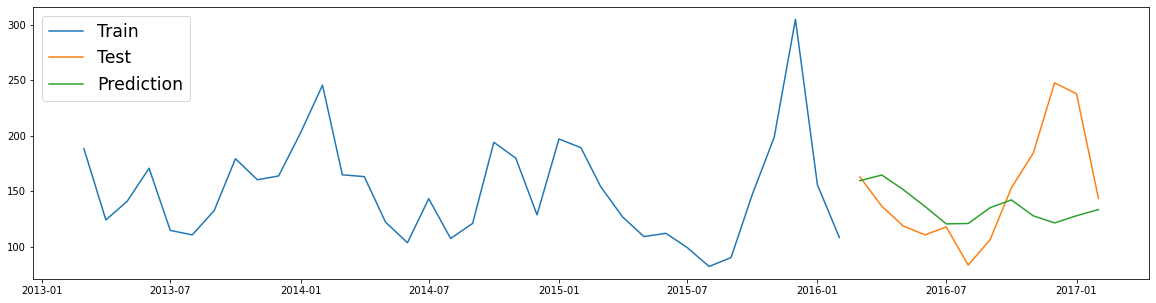


Predictions of  PM10


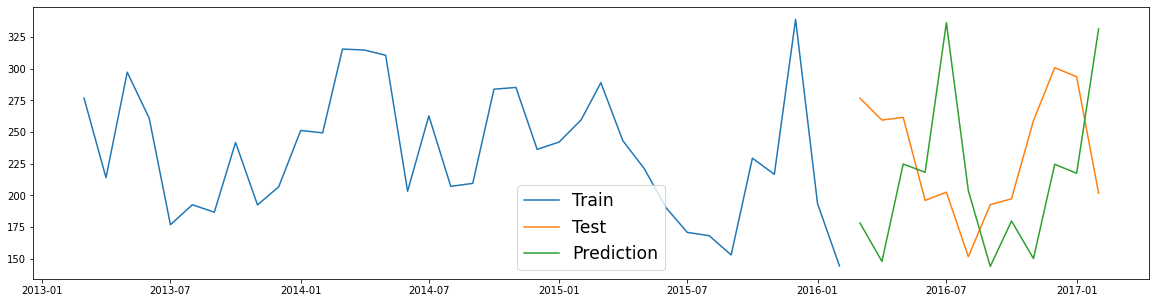


Predictions of  SO2


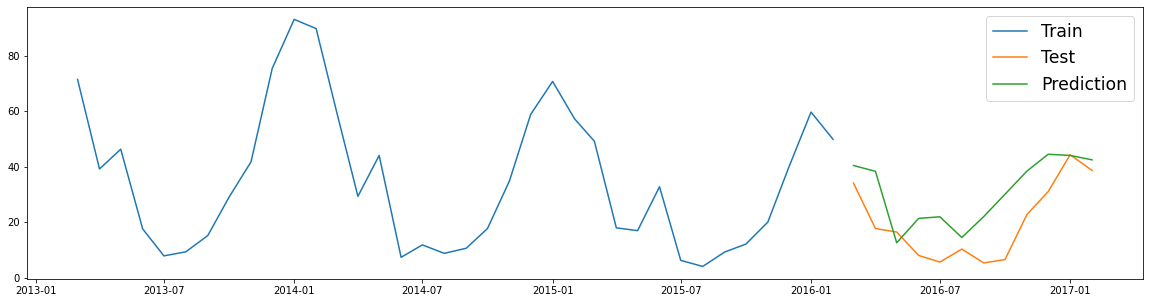


Predictions of  NO2


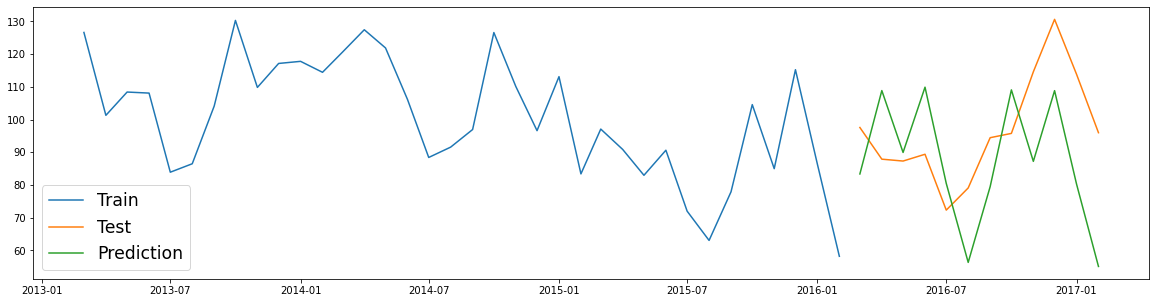


Predictions of  CO


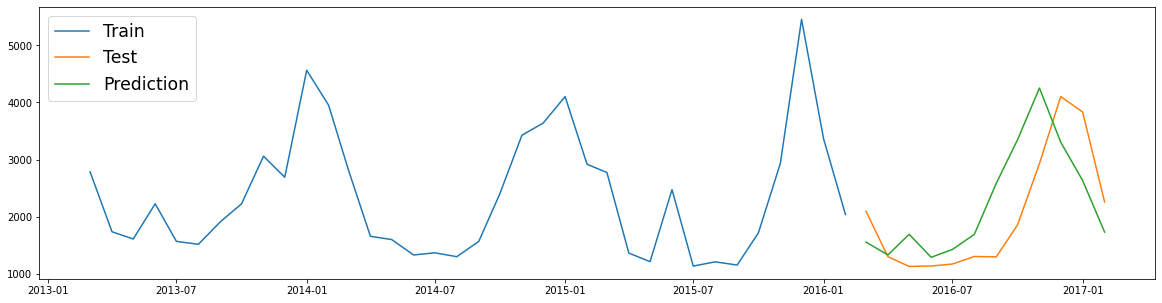


Predictions of  O3


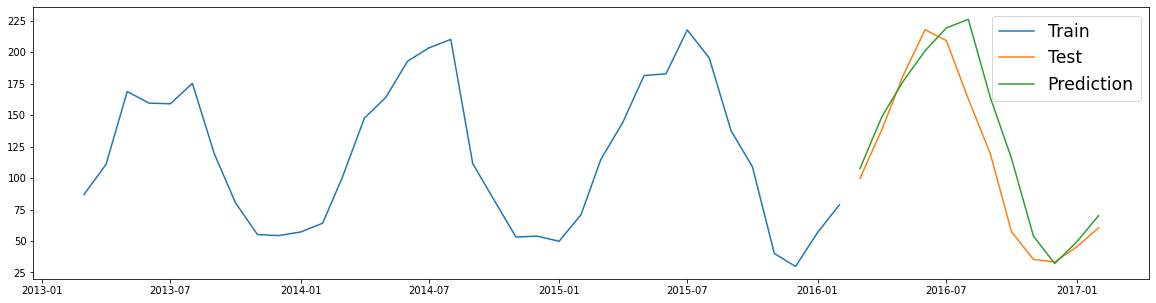

In [16]:
# Predict all the pollutants
list_predictions = [predict_RNN(list_scaled_train[i], list_scaler[i],list_train[i], list_test[i],time_steps,n_feature, list_models[i]) for i in range(len(list_scaled_train))]


In [17]:
list_file_path_and_names = ["/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/RNN_PM25.csv",
                            "/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/RNN_PM10.csv",
                            "/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/RNN_SO2.csv",
                            "/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/RNN_NO2.csv",
                            "/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/RNN_CO.csv",
                            "/content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/RNN_O3.csv",]

In [18]:
# Evaluate all the models
for i,j in zip(range(len(list_predictions)), list_file_path_and_names):
    # Evaluate each model
    evaluate_RNN(list_test[i], list_predictions[i],j)


Evaluation of  PM2.5
The Mean Squared Error of the forecasts is 3020.1038
The Mean Absolute Error of the forecasts is 39.4051
The Root Mean Squared Error of the forecasts is 54.9555

Results for PM2.5 successfully saved to /content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/RNN_PM25.csv

Evaluation of  PM10
The Mean Squared Error of the forecasts is 7306.9729
The Mean Absolute Error of the forecasts is 76.0615
The Root Mean Squared Error of the forecasts is 85.4808

Results for PM10 successfully saved to /content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/RNN_PM10.csv

Evaluation of  SO2
The Mean Squared Error of the forecasts is 185.1875
The Mean Absolute Error of the forecasts is 11.5264
The Root Mean Squared Error of the forecasts is 13.6084

Results for SO2 successfully saved to /content/drive/MyDrive/MLESS Project/predictions/Gucheng/monthly/RNN_SO2.csv

Evaluation of  NO2
The Mean Squared Error of the forecasts is 506.6182
The Mean Absolute Error of the

As we can see from the results, our model fit well only for CO, O3 and SO2 and somewhat for NO2.<br>
***Note: We can still improver the model performance by Hyperparameter Tuning. But due to Time and compute contraints we will skip Hyperparameter Tuning part.***